# Reading from example SITL CSV and sourcing relevant data

The code does two things:

- Puts an SITL report into a basic DataFrame.
- Creates calculated fields in DataFrame for filtering, BBF/DF identification, and Q.C.
- Extracts an "event" (BBF) from the report, loads the MMS data and plots the relevant time frame.

In [74]:
# Just to get rid of IPython deprecation warnings:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# std lib imports
import os
import datetime as dt
# 3rd party imports
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# local pkg imports
import pyspedas # as spds
import pytplot

# MeMes package imports:
import retrieve_sitl

In [117]:
os.chdir('/Users/payette/HW_20/mms_data_hunt/memes/')

#### Read the data using get()

This returns all the data, sorted but otherwise unchanged.

In [118]:
pickle_path = "../pydata/reports_df.p"
if os.path.exists(pickle_path):
    print("Reading pickle data")
    reports_df = pd.read_pickle(pickle_path)
else:
    print("Downloading data from source. This will take some minutes...")
    reports_df = retrieve_sitl.get()
    # Pickle the data for quicker loading because reading it takes forever:
    reports_df.to_pickle(pickle_path)

Reading pickle data


In [119]:
reports_df.head(10)

27-Aug-20 10:15:22: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



,datetime,FOM,ID,Discussion
0,2016-04-05/13:32:14 - 2016-04-05/13:35:54,20.0,jholmes(EVA),Continuation past crossing with some B rotati...
1,2016-04-05/13:43:24 - 2016-04-05/13:45:34,14.0,jholmes(EVA),Near boundary with B-field activity
2,2016-04-05/13:45:34 - 2016-04-05/13:47:54,8.0,jholmes(EVA),"E-field spikes, possible waves"
3,2016-04-05/13:48:24 - 2016-04-05/13:50:54,17.0,jholmes(EVA),"Strong E and B activity, ion flow reversal. B..."
4,2016-04-05/17:05:04 - 2016-04-05/17:07:04,18.0,jholmes(EVA),"Boundary skim, density gradient, E-field sign..."
5,2016-04-05/17:07:04 - 2016-04-05/17:09:04,18.0,jholmes(EVA),"Boundary skim, density gradient, E-field sign..."
6,2016-04-05/17:09:04 - 2016-04-05/17:11:04,18.0,jholmes(EVA),"Boundary skim, density gradient, E-field sign..."
7,2016-04-05/17:23:04 - 2016-04-05/17:24:24,15.0,jholmes(EVA),"Density, B gradients, E-field activity"
8,2016-04-05/20:23:54 - 2016-04-05/20:26:34,15.0,jholmes(EVA),"Gradual boundary crossing, Large density change"
9,2016-04-05/20:26:34 - 2016-04-05/20:29:14,17.0,jholmes(EVA),"Continued boundary crossing, B-field activity"


#### Parse the data so it's easier to work with

Split the datetime objects and combine all rows with identical discussions into one (while keeping the relevant start times and end times).

Add FOM field as new FLOAT column, add boolean fields for string searches for 'BBF' and 'DF' and Uncertainty keywords.

TODO: Add duration field calculated from datetime/Starttime/Endtime
TODO: Add a way to possibly identify multiple events in one start/endtime record. e.g. >1BBF or BBF+DF, etc.

In [120]:
#Initial parsing
reports_df = retrieve_sitl.parse_times(reports_df)
reports_df = reports_df.drop(columns='datetime') # Don't re-run this cell
reports_df = retrieve_sitl.combine_rows(reports_df)
reports_df.head(10)

27-Aug-20 10:15:23: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



,FOM,ID,Discussion,Starttime,Endtime,Day
0,20.0,jholmes(EVA),Continuation past crossing with some B rotati...,2016-04-05 13:32:14,2016-04-05 13:35:54,2016-04-05
1,14.0,jholmes(EVA),Near boundary with B-field activity,2016-04-05 13:43:24,2016-04-05 13:45:34,2016-04-05
2,8.0,jholmes(EVA),"E-field spikes, possible waves",2016-04-05 13:45:34,2016-04-05 13:47:54,2016-04-05
3,17.0,jholmes(EVA),"Strong E and B activity, ion flow reversal. B...",2016-04-05 13:48:24,2016-04-05 13:50:54,2016-04-05
4,18.0,jholmes(EVA),"Boundary skim, density gradient, E-field sign...",2016-04-05 17:05:04,2016-04-05 17:11:04,2016-04-05
5,15.0,jholmes(EVA),"Density, B gradients, E-field activity",2016-04-05 17:23:04,2016-04-05 17:24:24,2016-04-05
6,15.0,jholmes(EVA),"Gradual boundary crossing, Large density change",2016-04-05 20:23:54,2016-04-05 20:26:34,2016-04-05
7,17.0,jholmes(EVA),"Continued boundary crossing, B-field activity",2016-04-05 20:26:34,2016-04-05 20:29:14,2016-04-05
8,12.0,jholmes(EVA),"Boundary skimming. density gradient, E and B ...",2016-04-05 20:32:54,2016-04-05 20:35:54,2016-04-05
9,5.0,jholmes(EVA),Interesting ion populations near boundary,2016-04-05 20:35:54,2016-04-05 20:39:24,2016-04-05


In [121]:
# More parsing -- code could be optimized

reports_df['FOM_float'] = reports_df['FOM'].astype(float) # Add FOM as float for query operations
reports_df['Duration'] = (reports_df['Endtime']-reports_df['Starttime'])
reports_df['Discussion_contains_BBF'] = False #Create boolean field for BBF, initially set as False
reports_df['Discussion_contains_DF'] = False #Create boolean field for DF, initially set as False
reports_df['Discussion_contains_uncertainty'] = False

mask_BBF = reports_df.Discussion.str.contains('BBF',case=False) #Create mask, string search case insensitive for 'BBF'
mask_BBF2 = reports_df.Discussion.str.contains('bulk flow',case=False) 
mask_DF = reports_df.Discussion.str.contains('DF',case=False) #Create mask, string search case insensitive for 'DF'
mask_DF2 = reports_df.Discussion.str.contains('dipolarization',case=False)

mask_uncertainty  = reports_df.Discussion.str.contains("maybe")
mask_uncertainty2 = reports_df.Discussion.str.contains("possibl")
mask_uncertainty3 = reports_df.Discussion.str.contains("?", regex=False)

reports_df.loc[mask_BBF,'Discussion_contains_BBF'] = True #Set rows from mask equal to True
reports_df.loc[mask_BBF2,'Discussion_contains_BBF'] = True 
reports_df.loc[mask_DF,'Discussion_contains_DF'] = True #Set rows from mask equal to True
reports_df.loc[mask_DF2,'Discussion_contains_DF'] = True 

reports_df.loc[mask_uncertainty,'Discussion_contains_uncertainty'] = True
reports_df.loc[mask_uncertainty2,'Discussion_contains_uncertainty'] = True
reports_df.loc[mask_uncertainty3,'Discussion_contains_uncertainty'] = True

#reports_df['Discussion_contains_BBF'].iloc[18883] == True #Evaluate example for 'BBF' == TRUE
#reports_df['Discussion_contains_BBF'].iloc[2] == False #Evaluate example for no 'BBF' == FALSE

reports_df.head(5)

pickle_path = "../pydata/reports_parsed_df.p"
reports_df.to_pickle(pickle_path)

27-Aug-20 10:15:24: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [122]:
#Example query for finding a "high quality"? BBFs
#print count of these records
len(reports_df.query('Discussion_contains_uncertainty == False & Discussion_contains_BBF'))

235

#### Find an example BBF to extract and plot
Use a query of calculated fields from parsing

In [123]:
reports_df.query('Discussion.str.contains("multi")&(Discussion_contains_BBF==True|Discussion_contains_DF==True)')

27-Aug-20 10:15:26: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



,FOM,ID,Discussion,Starttime,Endtime,Day,FOM_float,Duration,Discussion_contains_BBF,Discussion_contains_DF,Discussion_contains_uncertainty
5083,110.0,tphan(EVA),possible multiple DFs with jets and waves.,2017-05-16 13:18:23,2017-05-16 13:45:43,2017-05-16,110.0,0 days 00:27:20,False,True,True
5115,160.0,tphan(EVA),multiple DFs with fast BBFs,2017-05-19 03:01:23,2017-05-19 03:14:33,2017-05-19,160.0,0 days 00:13:10,True,True,False
5127,140.0,tphan(EVA),"multiple Bz enhancements and BBF, intense E",2017-05-19 20:10:53,2017-05-19 20:14:43,2017-05-19,140.0,0 days 00:03:50,True,False,False
5215,140.0,ykhotyaintsev(EVA),BBF and multiple DFs,2017-05-28 06:01:43,2017-05-28 06:25:13,2017-05-28,140.0,0 days 00:23:30,True,True,False
5555,120.0,pgangkai(EVA),Flow enhancement; multiple DF,2017-06-22 07:11:33,2017-06-22 07:14:23,2017-06-22,120.0,0 days 00:02:50,False,True,False
5563,120.0,pgangkai(EVA),Flow enhancements; Possible multiple DF,2017-06-22 09:11:23,2017-06-22 09:20:03,2017-06-22,120.0,0 days 00:08:40,False,True,False
5568,120.0,pgangkai(EVA),Flow enhancements; multiple DF,2017-06-22 09:54:53,2017-06-22 10:01:03,2017-06-22,120.0,0 days 00:06:10,False,True,False
5569,120.0,pgangkai(EVA),flow enhancement; multiple DF,2017-06-22 10:22:23,2017-06-22 10:32:13,2017-06-22,120.0,0 days 00:09:50,False,True,False
5662,140.0,dozturk(EVA),Sequential flow enhancements up to 1000 km/s...,2017-06-28 16:27:43,2017-06-28 16:32:33,2017-06-28,140.0,0 days 00:04:50,False,True,False
5708,120.0,dozturk(EVA),"Flow enhancement in +x direction, multiple d...",2017-07-01 08:16:23,2017-07-01 08:20:33,2017-07-01,120.0,0 days 00:04:10,False,True,False


In [124]:
reports_df.query('FOM_float > 40 & Discussion_contains_BBF == True & Discussion_contains_uncertainty == False').tail(5)

27-Aug-20 10:15:27: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



,FOM,ID,Discussion,Starttime,Endtime,Day,FOM_float,Duration,Discussion_contains_BBF,Discussion_contains_DF,Discussion_contains_uncertainty
18881,120.0,tphan(EVA),BBF/PSBL,2020-07-11 18:47:33,2020-07-11 18:50:33,2020-07-11,120.0,0 days 00:03:00,True,False,False
18882,120.0,tphan(EVA),3 BBFs,2020-07-11 19:04:13,2020-07-11 19:47:23,2020-07-11,120.0,0 days 00:43:10,True,False,False
18883,110.0,tphan(EVA),BBF,2020-07-11 19:45:13,2020-07-11 20:48:23,2020-07-11,110.0,0 days 01:03:10,True,False,False
18884,110.0,tphan(EVA),2 long BBFs,2020-07-11 21:22:33,2020-07-11 21:49:13,2020-07-11,110.0,0 days 00:26:40,True,False,False
18887,130.0,tphan(EVA),multiple DFs and BBFs,2020-07-13 05:35:53,2020-07-13 06:00:23,2020-07-13,130.0,0 days 00:24:30,True,True,False


In [145]:
reports_df.query('Discussion_contains_BBF == True & Discussion_contains_uncertainty == False')[reports_df.Discussion.str.contains('\d+[a-z]',regex=True)]

27-Aug-20 10:43:04: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

27-Aug-20 10:43:04: <>:1: DeprecationWarning: invalid escape sequence \d

27-Aug-20 10:43:04: <>:1: DeprecationWarning: invalid escape sequence \d

27-Aug-20 10:43:04: <>:1: DeprecationWarning: invalid escape sequence \d

27-Aug-20 10:43:04: <ipython-input-145-876d14594f7a>:1: DeprecationWarning: invalid escape sequence \d
  reports_df.query('Discussion_contains_BBF == True & Discussion_contains_uncertainty == False')[reports_df.Discussion.str.contains('\d+[a-z]',regex=True)]

27-Aug-20 10:43:04: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be

,FOM,ID,Discussion,Starttime,Endtime,Day,FOM_float,Duration,Discussion_contains_BBF,Discussion_contains_DF,Discussion_contains_uncertainty
5280,120.0,nahmadi(EVA),"BBF, Velocity 100km/s",2017-06-05 05:45:53,2017-06-05 05:49:53,2017-06-05,120.0,0 days 00:04:00,True,False,False
6616,142.0,rtorbert(EVA),"BBFs, Bz revesals, Bx,B to 0current spike",2017-08-15 07:16:23,2017-08-15 07:27:23,2017-08-15,142.0,0 days 00:11:00,True,False,False
11653,100.0,dozturk(EVA),"50mV/m bi-polar electric field pulses, BBF an...",2018-06-30 21:08:53,2018-06-30 21:16:03,2018-06-30,100.0,0 days 00:07:10,True,True,False
11746,155.0,avaivads(EVA),"BBF, embedded Bz>10nT, strong E, energetic e-...",2018-07-09 15:41:43,2018-07-09 15:44:13,2018-07-09,155.0,0 days 00:02:30,True,False,False
11783,120.0,avaivads(EVA),"BBF, Vx+ flow up to 1000km/s, Bz fluctuations...",2018-07-12 08:09:03,2018-07-12 08:12:43,2018-07-12,120.0,0 days 00:03:40,True,False,False
11810,125.0,avaivads(EVA),"BBF/PSBL, Vx +300..-200km/s flow, Bz bump",2018-07-15 02:40:43,2018-07-15 02:45:43,2018-07-15,125.0,0 days 00:05:00,True,False,False
11811,120.0,avaivads(EVA),"BBF/PSBL, Vx+300..-200km/s flow, Bz fluctuat...",2018-07-15 02:45:43,2018-07-15 02:50:43,2018-07-15,120.0,0 days 00:05:00,True,False,False
12175,105.0,ocontel(EVA),"BBF with embedded DF, Vx 800km/s, large Efie...",2018-08-26 17:51:03,2018-08-26 17:55:13,2018-08-26,105.0,0 days 00:04:10,True,True,False
12203,90.0,ocontel(EVA),"BBF, B> 5nT, Vx 200 km/s, E waves",2018-08-27 08:56:53,2018-08-27 09:01:23,2018-08-27,90.0,0 days 00:04:30,True,False,False
12212,90.0,ocontel(EVA),"BBF, B<5nT, Vx 400km/s, large Ey 20mV/m, E&B...",2018-08-27 10:09:53,2018-08-27 10:13:13,2018-08-27,90.0,0 days 00:03:20,True,False,False


In [128]:
# Take an example from dataframe:
n_event = 18884    # pick index of example event (data needs to exist!)
test_event = reports_df.loc[n_event]
description = test_event['Discussion']
starttime = test_event['Starttime']
endtime = test_event['Endtime']

# Extract dates of data we'll need for event:
trange = [(starttime - dt.timedelta(days=1)).strftime('%Y-%m-%d'), 
          (endtime + dt.timedelta(days=1)).strftime('%Y-%m-%d')]
plt_tlims = (starttime - dt.timedelta(minutes=15),
             endtime + dt.timedelta(minutes=15))
print("Using range of dates:", [starttime, endtime])

Using range of dates: [Timestamp('2020-07-11 21:22:33'), Timestamp('2020-07-11 21:49:13')]


## Read MMS data

Run the first block to download the data - if you've already downloaded the data, ignore it!. The following blocks will read the downloaded files using either CDFLIB or (below) pyspedas. CDFLIB is far faster!

In [129]:
# ----------------------------------------------
# RUN THIS BLOCK TO DOWNLOAD DATA TO LOCAL PATH
# ----------------------------------------------

# update local data dir if using no_update flag
pyspedas.mms.mms_config.CONFIG['local_data_dir'] = '../pydata'

# load B-field data from FGM (Fluxgate Magnetometer)
# use no_update=True to load local data
fgm_vars = pyspedas.mms.fgm(
    trange       =  trange,
    time_clip    =   False, # could truncate residuals at trange ends
    data_rate    =  'srvy', # survey frequency
    level        =    'l2', # ensure L2 products
    probe        =     '1', # could be ['1','2','3','4'] for all spacecraft
    no_update    =    True, # Flag set to True to automatically download new data from server
)

27-Aug-20 10:19:04: Searching for local files...


Loading: ../pydata/mms1/fgm/srvy/l2/2020/07/mms1_fgm_srvy_l2_20200711_v5.254.0.cdf
Loading: ../pydata/mms1/fgm/srvy/l2/2020/07/mms1_fgm_srvy_l2_20200711_v5.254.0.cdf
Loaded variables:
mms1_fgm_b_gse_srvy_l2
mms1_fgm_b_gsm_srvy_l2
mms1_fgm_b_dmpa_srvy_l2
mms1_fgm_b_bcs_srvy_l2
mms1_fgm_flag_srvy_l2
mms1_fgm_r_gse_srvy_l2
mms1_fgm_r_gsm_srvy_l2
mms1_fgm_hirange_srvy_l2
mms1_fgm_bdeltahalf_srvy_l2
mms1_fgm_stemp_srvy_l2
mms1_fgm_etemp_srvy_l2
mms1_fgm_mode_srvy_l2
mms1_fgm_rdeltahalf_srvy_l2


#### Read using CDF library (fast)

Reads data within the time range (plt_tlims here) specified, assuming that the files exist locally under the path base_path.

In [130]:
import retrieve_mms

local_data_dir = '../pydata'
base_path = os.path.join(local_data_dir, 'mms1', 'fgm', 'srvy', 'l2')
data = retrieve_mms.get_fgm(base_path, plt_tlims[0], plt_tlims[1])
t_utc, B_x, B_y, B_z, Bt = data

27-Aug-20 10:20:39: /Users/payette/HW_20/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Reading file at ../pydata/mms1/fgm/srvy/l2/2020/07/mms1_fgm_srvy_l2_20200711_v5.254.0.cdf


## Plot the data

Reading seems to have worked and has picked out the time of interesting signals, so let's plot...

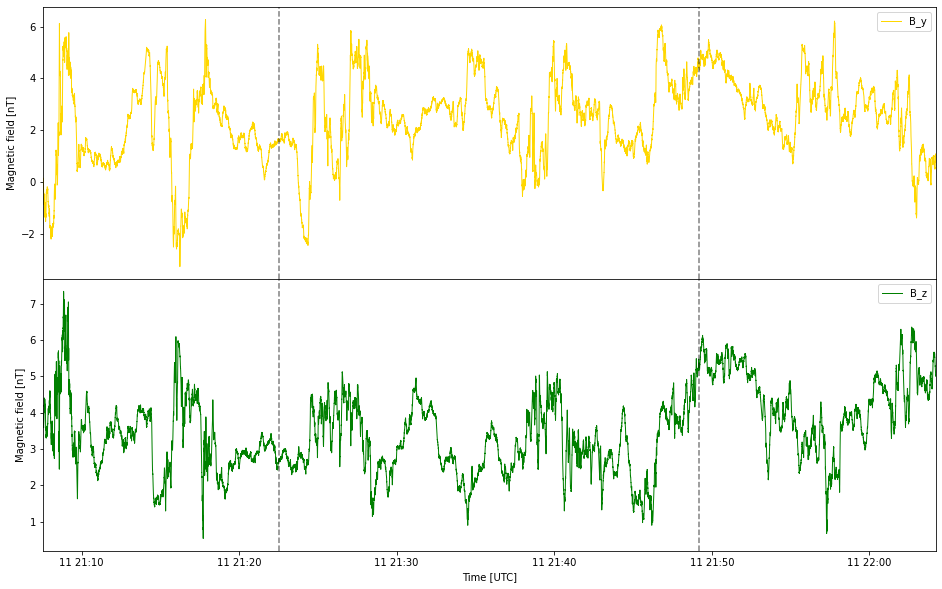

In [131]:
# convert to datetime axis
inds = np.where(np.logical_and(t_utc > plt_tlims[0], t_utc < plt_tlims[1]))

#----------------------------------------------------------------------
# plotting below
#----------------------------------------------------------------------

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,10), sharex=True)
ax1.plot_date(t_utc[inds], B_y[inds], '-', lw=1, c='gold', label='B_y')
ax2.plot_date(t_utc[inds], B_z[inds], '-', lw=1, c='green', label='B_z')
ax1.axvline(test_event['Starttime'], ls='--', c='k', alpha=0.5)
ax1.axvline(test_event['Endtime'], ls='--', c='k', alpha=0.5)
ax2.axvline(test_event['Starttime'], ls='--', c='k', alpha=0.5)
ax2.axvline(test_event['Endtime'], ls='--', c='k', alpha=0.5)
ax2.set_xlim(plt_tlims)
ax1.set_ylabel("Magnetic field [nT]")
ax2.set_ylabel("Magnetic field [nT]")
ax2.set_xlabel("Time [UTC]")
ax1.legend()
ax2.legend()
plt.subplots_adjust(hspace=0.)
plt.show()

#### Possible TODO -- after looking at this plot, we could have a manual write back to the SITL df to qualify this, with a boolean to mark it as a confirmed event.

#### Old example: Read a single SITL report (example CSV) file

In [ ]:
# Read an example CSV file
sitl_df = pd.read_csv("../example/example_sitl_reports.csv", usecols=[0,1,2,3])

# Split the time column into start time and end time:
sitl_df[['STARTTIME','ENDTIME']] = sitl_df['START TIME - END TIME'].str.split(" - ", expand=True)
# Parse the time columns into datetime objects:
tformat_sitl = '%Y-%m-%d/%H:%M:%S'
sitl_df['STARTTIME'] = pd.to_datetime(sitl_df['STARTTIME'], format=tformat_sitl)
sitl_df['ENDTIME'] = pd.to_datetime(sitl_df['ENDTIME'], format=tformat_sitl)
# Remove the original time format:
sitl_df = sitl_df.drop(columns='START TIME          - END TIME')

sitl_df.head(15)

#### Old method: Load MMS data using pytplot (slow)

In [7]:
alldata = pytplot.get_data('mms1_fgm_b_gsm_srvy_l2')

# Extract data:
t = alldata[0]
B_x = alldata[1][:,0]
B_y = alldata[1][:,1]
B_z = alldata[1][:,2]
Bt = alldata[1][:,3]

t_utc = np.array([dt.datetime.utcfromtimestamp(i) for i in t])

26-Aug-20 13:12:20: Searching for local files...


Loading: ../pydata/mms1/fgm/srvy/l2/2016/05/mms1_fgm_srvy_l2_20160521_v4.40.0.cdf
Loading: ../pydata/mms1/fgm/srvy/l2/2016/05/mms1_fgm_srvy_l2_20160522_v4.40.0.cdf
Loading: ../pydata/mms1/fgm/srvy/l2/2016/05/mms1_fgm_srvy_l2_20160521_v4.40.0.cdf
Loading: ../pydata/mms1/fgm/srvy/l2/2016/05/mms1_fgm_srvy_l2_20160522_v4.40.0.cdf
The lengths of x and y do not match!
mms1_fgm_rdeltahalf_srvy_l2 is currently not in pytplot.
Loaded variables:
mms1_fgm_b_gse_srvy_l2
mms1_fgm_b_gsm_srvy_l2
mms1_fgm_b_dmpa_srvy_l2
mms1_fgm_b_bcs_srvy_l2
mms1_fgm_flag_srvy_l2
mms1_fgm_r_gse_srvy_l2
mms1_fgm_r_gsm_srvy_l2
mms1_fgm_hirange_srvy_l2
mms1_fgm_bdeltahalf_srvy_l2
mms1_fgm_stemp_srvy_l2
mms1_fgm_etemp_srvy_l2
mms1_fgm_mode_srvy_l2
mms1_fgm_rdeltahalf_srvy_l2
